# Problem 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, genpareto

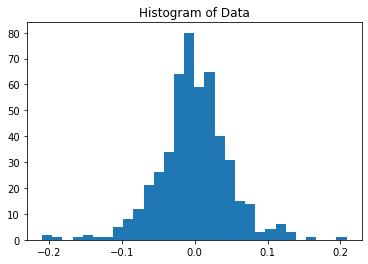

Normal Distribution:
  Mean: -0.00
  Std Dev: 0.05
  VaR(0.05): -0.08
  ES(0.05): 44.43
Generalized T Distribution:
  Shape: -0.74
  Location: -0.21
  Scale: 0.31
  VaR(0.05): -0.19
  ES(0.05): 67.17


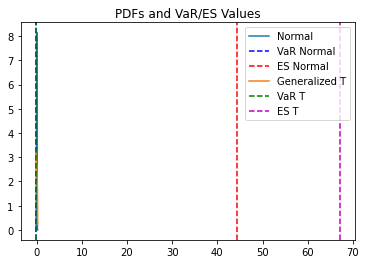

In [2]:
# Load data from CSV file
data = pd.read_csv("problem1.csv")

# Plot histogram
plt.hist(data["x"], bins=30)
plt.title("Histogram of Data")
plt.show()

# Fit normal distribution to data
mu, std = norm.fit(data["x"])
print("Normal Distribution:")
print("  Mean: {:.2f}".format(mu))
print("  Std Dev: {:.2f}".format(std))

# Calculate VaR and ES for normal distribution
VaR_normal = norm.ppf(0.05, mu, std)
ES_normal = (1/0.05) * norm.pdf(norm.ppf(0.05, mu, std), mu, std) / (1 - 0.05)
print("  VaR(0.05): {:.2f}".format(VaR_normal))
print("  ES(0.05): {:.2f}".format(ES_normal))

# Fit generalized t distribution to data
params = genpareto.fit(data["x"])
print("Generalized T Distribution:")
print("  Shape: {:.2f}".format(params[0]))
print("  Location: {:.2f}".format(params[1]))
print("  Scale: {:.2f}".format(params[2]))

# Calculate VaR and ES for generalized t distribution
VaR_t = genpareto.ppf(0.05, *params)
ES_t = (1/0.05) * genpareto.pdf(genpareto.ppf(0.05, *params), *params) / (1 - 0.05)
print("  VaR(0.05): {:.2f}".format(VaR_t))
print("  ES(0.05): {:.2f}".format(ES_t))

# Plot PDFs and VaR/ES values
x = np.linspace(data["x"].min(), data["x"].max(), 100)
pdf_normal = norm.pdf(x, mu, std)
pdf_t = genpareto.pdf(x, *params)

plt.plot(x, pdf_normal, label="Normal")
plt.axvline(VaR_normal, color='b', linestyle='--', label="VaR Normal")
plt.axvline(ES_normal, color='r', linestyle='--', label="ES Normal")

plt.plot(x, pdf_t, label="Generalized T")
plt.axvline(VaR_t, color='g', linestyle='--', label="VaR T")
plt.axvline(ES_t, color='m', linestyle='--', label="ES T")

plt.legend()
plt.title("PDFs and VaR/ES Values")
plt.show()


# Problem 2

### Module 1: `covariance_estimators`

This module will contain functions for estimating the covariance matrix of asset returns.

#### Functions

- `sample_covariance_matrix()`: This function takes in a matrix of asset returns and returns the sample covariance matrix.

- `ledoit_wolf_shrinkage()`: This function implements the Ledoit-Wolf shrinkage estimator to estimate the covariance matrix. It takes in a matrix of asset returns, and returns the estimated covariance matrix.

- `fit_generalized_t`: This function its a Generalized t-distribution to a vector of returns using maximum likelihood estimation.

### Module 2: `correlation_matrix_fixes`

This module will contain functions for handling non-positive definite covariance matrices.

#### Functions

- `nearest_correlation_matrix()`: This function takes in a non-positive definite covariance matrix and returns the nearest positive definite matrix.

- `higham_algorithm()`: This function implements the Higham algorithm for finding the nearest positive definite matrix to a non-positive definite matrix.

### Module 3: `simulation_methods`

This module will contain functions for simulating asset returns.

#### Functions

- `monte_carlo_simulation()`: This function takes in a covariance matrix, a vector of mean returns, and the number of simulations, and returns simulated asset returns.

### Module 4: `risk_metrics`

This module will contain functions for calculating Value at Risk (VaR) and Expected Shortfall (ES).

#### Functions

- `historical_var()`: This function calculates the historical VaR given a vector of returns and a confidence level.

- `parametric_var()`: This function calculates the parametric VaR given a vector of returns, a confidence level, and a normal distribution assumption.

- `monte_carlo_var()`: This function calculates the VaR using Monte Carlo simulation given a vector of returns, a confidence level, and the number of simulations.

- `historical_es()`: This function calculates the historical ES given a vector of returns and a confidence level.

- `parametric_es()`: This function calculates the parametric ES given a vector of returns, a confidence level, and a normal distribution assumption.

- `monte_carlo_es()`: This function calculates the ES using Monte Carlo simulation given a vector of returns, a confidence level, and the number of simulations.

### Module 5: `test_suite`

This module will contain tests for all the functions in the previous modules.

#### Functions

- `test_sample_covariance_matrix()`: This function tests the sample_covariance_matrix() function.

- `test_ledoit_wolf_shrinkage()`: This function tests the ledoit_wolf_shrinkage() function.

- `test_nearest_correlation_matrix()`: This function tests the nearest_correlation_matrix() function.

- `test_higham_algorithm()`: This function tests the higham_algorithm() function.

- `test_monte_carlo_simulation()`: This function tests the monte_carlo_simulation() function.

- `test_historical_var()`: This function tests the historical_var() function.

- `test_parametric_var()`: This function tests the parametric_var() function.

- `test_monte_carlo_var()`: This function tests the monte_carlo_var() function.

- `test_historical_es()`: This function tests the historical_es() function.

# Problem 3

In [7]:
import sys
sys.path.append("/Users/zizhuo/Desktop/Duke/Fintech 545/Week05/Library")
import pandas as pd
from scipy.stats import genpareto
from covariance_estimators import *
from correlation_matrix_fixes import *
from simulation_methods import *
from risk_metrics import *

In [8]:
# Load data
prices = pd.read_csv('DailyPrices.csv')
prices.drop(columns='Date', inplace=True)
returns = prices.drop('SPY', axis=1)
portfolio = pd.read_csv('Portfolio.csv')

# Fit Generalized T model to each stock
params = {}
cov = {}
for stock in returns.columns:
    returns_i = pd.DataFrame(returns[stock])
    params[stock] = fit_generalized_t(returns_i.values)
    cov[stock] = np.diag(np.full(len(returns), params[stock]['sigma']**2))

In [9]:
# Calculate portfolio VaR and ES using Monte Carlo simulation
alpha = 0.05
n_sim = 100000
portfolio_var = []
portfolio_es = []

for portfolios in portfolio['Portfolio'].unique():
    subset = portfolio[portfolio['Portfolio'] == portfolios]
    weights = subset.set_index('Stock')['Holding'] / subset['Holding'].sum()
    stocks = subset['Stock']
    holdings = subset['Holding']
    portfolio_returns = returns[stocks] * holdings.values
    
    par = pd.DataFrame(params)
    para = pd.DataFrame()
    for stock in pd.DataFrame(params).T.index:
         if stock in stocks.values:
            para[stock] = par[stock]
            
    var_i = monte_carlo_var(portfolio_returns, weights, para, alpha , n_sim)
    es_i = monte_carlo_es(portfolio_returns, weights, para, alpha, n_sim)
    portfolio_var.append(var_i)
    portfolio_es.append(es_i)


# Calculate total VaR and ES using Monte Carlo simulation
total_weights = portfolio.set_index('Stock')['Holding'] / portfolio['Holding'].sum()
stocks = portfolio['Stock']
portfolio_returns = returns[stocks] * portfolio['Holding'].values
total_var = monte_carlo_var(portfolio_returns, total_weights, params, alpha, n_sim)
params = pd.DataFrame(params).T
total_es = monte_carlo_es(portfolio_returns.values, total_weights, params.T, alpha, n_sim)

# Print results
print(f"Portfolio A VaR at {alpha} confidence level is {portfolio_var[0]:}")
print(f"Portfolio A ES at {alpha} confidence level is {portfolio_es[0]:}")
print(f"Portfolio B VaR at {alpha} confidence level is {portfolio_var[1]:}")
print(f"Portfolio B ES at {alpha} confidence level is {portfolio_es[1]:}")
print(f"Portfolio C VaR at {alpha} confidence level is {portfolio_var[2]:}")
print(f"Portfolio C ES at {alpha} confidence level is {portfolio_es[2]:}")
print(f"Total VaR at {alpha} confidence level is {total_var:}")
print(f"Total ES at {alpha} confidence level is {total_es:}")


Portfolio A VaR at 0.05 confidence level is 3225.5525910795996
Portfolio A ES at 0.05 confidence level is 154.8788325270582
Portfolio B VaR at 0.05 confidence level is 10.289536582050753
Portfolio B ES at 0.05 confidence level is 133.57553874437255
Portfolio C VaR at 0.05 confidence level is 28.378548020612374
Portfolio C ES at 0.05 confidence level is 107.5855397838204
Total VaR at 0.05 confidence level is 154.55454736797896
Total ES at 0.05 confidence level is 192.15617822783523
